# In this notebook we implement CNN architecture from scratch with numpy, contains:
- `Convolutional` layer
- `Max_pooling` layer
- `Dense` layer
- `Activations`: 
  - Relu: introduce non-linearity to CNN's block
  - Sigmoid: for binary classification problems
  - Softmax: for categorical classfication problems
- `Loss` function: Binary crossen entropy
- Chosen initialization: `He normal`

All of mentioned above are implemented from scratch with numpy. Each function above includes `forward` operation as well as `backward` operation.

In [279]:
import numpy as  np
from convulutional import Convlutional
from network import Network, preprocess_data
from dense import Dense
from losses import binary_cross_entropy, binary_cross_entropy_prime
from activations import Sigmoid, Relu, Softmax
from keras.datasets import mnist
from reshape import Reshape
import matplotlib.pyplot as plt
from pooling import Pooling
import tensorflow as tf 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preproccess MNIST dataset
- Since we train the data on the `CPU`, which is quite `slow` in comparison to `GPU`. So we limit the train dataset to `2000` examples, which takes about `1 hour` to train with `200 epochs`.
- We then evaluate the model on `1000 examples test dataset`. The model should be expected to produced approximately `92% accuracy` on test set.

In [427]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

np.random.seed(1)
# Limit the data to 2000 and one-hot encoded y
x_train, y_train = preprocess_data(x_train, y_train, 2000)
x_test, y_test = preprocess_data(x_test, y_test, 1000)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('\ny_train first example:', y_train[0])
print(f'The number "1" is at index: {np.argmax(y_train[0])}, \nindicating the first example is number: {np.argmax(y_train[0])}')

y_train shape: (2000, 10)
y_test shape: (1000, 10)

y_train first example: [0 0 0 0 0 1 0 0 0 0]
The number "1" is at index: 5, 
indicating the first example is number: 5


##### You can see that the labels are one-hot encoded

## CNN's architecture
- By convention the `CNN's architectures` usually has this block: `CONV -> Pooling (usually Max poolin) -> Activation (Relu).`
  - The `CONV` layers try to `extract` features.
  - The `Pooling` layers try to `downside` the data to `reduce computational` resources as well as hope to `extract` the `most outstading features`.
  - The `Activation` layers introduce `non-linearity` to arichitecture (often Relu since it's much faster than Sigmoid).
  - Then the model finishs with `Dense -> Activation(Softmax)` layer

  
<div style="text-align:center">
    <img src='./img/cnn.png' style="max-width:900px" />
    <p style="margin-top: 10px; color:orange">Convolutional Neural Network — CNN architecture</p>
</div>



### Define CNN's architecture, and choose hyper-parameters:
- loss function 
- num of epochs
- learning_rate

In [223]:
# Define CNN's architecture
network = [
    # First CNN's block
    Convlutional((1, 28, 28), (10, 1, 3, 3)),
    Pooling(stride=2, size=2),
    Relu(),
    # Second CNN's block
    Convlutional((10, 13, 13), (5, 1, 2, 2)),
    Pooling(stride=2, size=2),
    Relu(),
    # Dense Layer
    Reshape((5, 6, 6), (5*6*6, 1)),
    Dense(10, 5*6**2),
    Softmax()
]
# Instantiate the Network
net = Network(network)

# Set the hyper-parameters: loss function, epoch, learning_rate
net.train(x_train, y_train, binary_cross_entropy, binary_cross_entropy_prime, epochs=200, learning_rate=0.015)

Epoch 0, loss: 0.33020790098614483
Epoch 10, loss: 0.09464614418313558
Epoch 20, loss: 0.06118897366018239
Epoch 30, loss: 0.04583635418482612
Epoch 40, loss: 0.03701471070916994
Epoch 50, loss: 0.030903349022840074
Epoch 60, loss: 0.026100219317863983
Epoch 70, loss: 0.02224966001884469
Epoch 80, loss: 0.019085132811004733
Epoch 90, loss: 0.016245400540491867
Epoch 100, loss: 0.01376837355498506
Epoch 110, loss: 0.01166594380438488
Epoch 120, loss: 0.009891957201022603
Epoch 130, loss: 0.008435777122028145
Epoch 140, loss: 0.00721527733028409
Epoch 150, loss: 0.006184487405135977
Epoch 160, loss: 0.005356533448849344
Epoch 170, loss: 0.0046892137760048665
Epoch 180, loss: 0.004107198902165075
Epoch 190, loss: 0.0036343779823332827


## Evaluate the model on the test set
### Make predictions on test dataset. 

In [291]:
ypred_list = []
for x, y in zip(x_test, y_test): 
    ypred = net.predict(x)
    ypred_onehot = np.zeros(ypred.shape)
    ypred_onehot[np.argmax(ypred)] = 1
    ypred_list.append(ypred_onehot)
ypred_list = np.array(ypred_list, dtype='int32')    

In [389]:
a = ypred_list
a.shape
b = a.reshape(a.shape[0], 10).T

In [390]:
count = 0
m_test = b.shape[1]
miss_indices = []
for i in range(m_test): 
    index_pred = np.argmax(b[:, i])
    index_y_test = np.argmax(y_test.T[:, i])
    if index_pred == index_y_test: 
        count += 1
    else: 
        miss_indices.append(i)


### 91.6% in term of accuracy on test dataset

In [399]:
accuracy = count / m_test
print(f'Accuracy on test set: {float(f"{accuracy*100:.2f}")}%')

Accuracy on test set: 91.6%


In [392]:
accurate_indices = [x for x in range(m_test) if x not in miss_indices]

## Visualize the accurate predictions


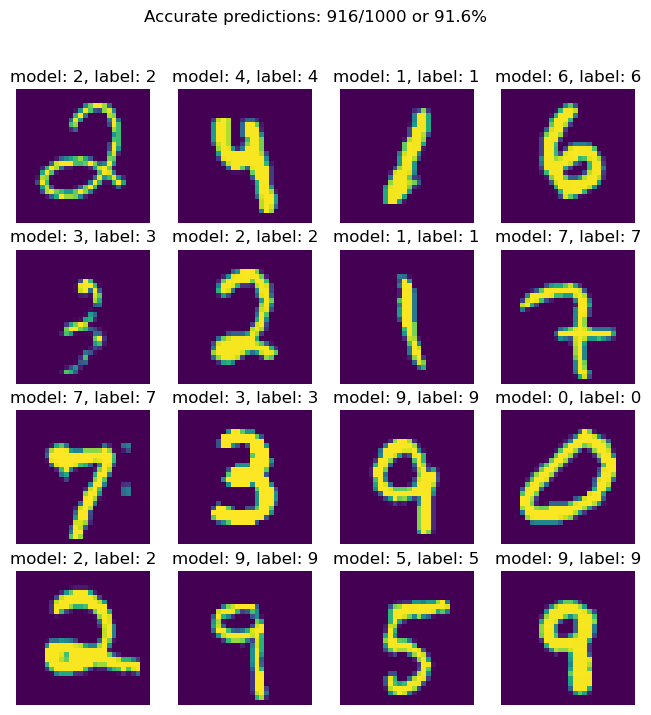

In [426]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
# Set a title for the entire figure
plt.suptitle(f'Accurate predictions: {count}/{m_test} or {float(f"{accuracy*100:.2f}")}%')
for i in range(1, columns*rows +1):
    try: 
        random_chosen = np.random.choice(accurate_indices)
        img = x_test[random_chosen]
        fig.add_subplot(rows, columns, i)
        plt.title(f'model: {np.argmax(b.T[random_chosen])}, label: {np.argmax(y_test[random_chosen])}')
        plt.imshow(img)
        plt.axis('off')
    except: 
        pass
plt.show()

## Misslabeled results

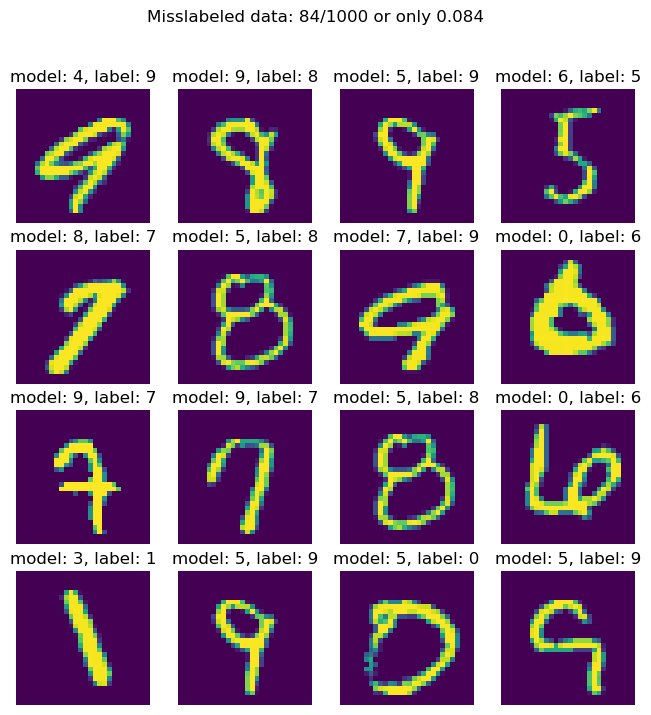

In [412]:
w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 4
# Set a title for the entire figure
plt.suptitle(f'Misslabeled data: {m_test - count}/{m_test} or only {(m_test - count)/m_test}')
for i in range(1, columns*rows +1):
    try: 
        random_chosen = np.random.choice(miss_indices)
        img = x_test[random_chosen]
        fig.add_subplot(rows, columns, i)
        plt.title(f'model: {np.argmax(b.T[random_chosen])}, label: {np.argmax(y_test[random_chosen])}')
        plt.imshow(img)
        plt.axis('off')
    except: 
        pass
plt.show()